# Description of the MNIST Handwritten Digit Recognition Problem
The MNIST problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem.

The dataset was constructed from a number of scanned document dataset available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.

Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required.

Each image is a 28 by 28 pixel square (784 pixels total). A standard split of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.

It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. Results are reported using prediction error, which is nothing more than the inverted classification accuracy.

Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks.
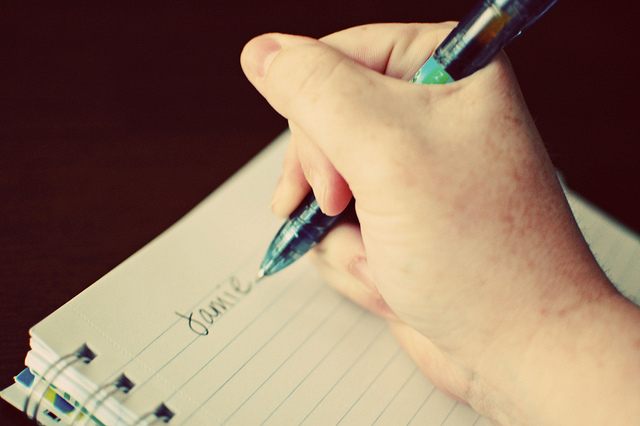

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Loading the MNIST dataset in Keras

In [ ]:
train_df = pd.read_csv("../input/digit-recognizer/train.csv")
test_df = pd.read_csv("../input/digit-recognizer/test.csv")
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

In [ ]:
train_df.head()

# Data Visualization and Preprocessing

In [ ]:
plt.figure(figsize = (10,10)) # Label Count
sns.set(style="darkgrid")
sns.countplot(train_df['label'])

**The dataset seems balanced as for each training label , enough training examples exist**

In [ ]:
y_train = train_df['label']
y = train_df['label']
del train_df['label']

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)

In [ ]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Preview of first 10 images**

In [ ]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# Using Data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

# Training The Model

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.1 , random_state = 0)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(128 , (2,2) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128 , (2,2) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128 , (2,2) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 10 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 30,validation_data = (x_val, y_val) ,callbacks=[learning_rate_reduction] )

In [ ]:
print("Accuracy of the model on Validation Data is - " , model.evaluate(x_val,y_val)[1]*100 , "%")

# Analysis after Model Training

In [ ]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred_val = model.predict_classes(x_val)
pred_val[:5]

In [ ]:
new_y_val = []
for i in y_val:
    new_y_val.append(i.argmax())
new_y_val[:5]    

In [ ]:
classes = ["Number " + str(i) for i in range(10)]
print(classification_report(new_y_val, pred_val, target_names = classes))

In [ ]:
cm = confusion_matrix(new_y_val,pred_val)
cm

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(10)] , columns = [i for i in range(10)])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap = "Blues", linecolor = 'black' , linewidth = 1 , annot = True , fmt = '')

In [ ]:
correct = np.nonzero(pred_val == new_y_val)[0]
incorrect = np.nonzero(pred_val != new_y_val)[0]

**Some of the Correctly Predicted Classes**

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_val[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(pred_val[c], new_y_val[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_val[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(pred_val[c], new_y_val[c]))
    plt.tight_layout()
    i += 1

**We can see that the labels it has incorrectly predicted are actually really close**

In [ ]:
predictions = model.predict_classes(x_test)
predictions[:5]

In [ ]:
submission['Label'] = predictions
submission.to_csv("submission.csv" , index = False)

In [ ]:
submission.head()